# 🚑 Using Google maps routing service over hospital referral regions as a strategy to improve ambulance time to arrival

### Summary

Hospital Referral Regions are geographical regions that are under the sphere of influence of one of the 13 designated emergency hospitals in Buenos Aires City. While a convinient definition for burocratic purposes, a hospital selected for each area my not alway be the nearest nor the fastest to reach, specially during rush hour traffic, bearing a direct impact on the ambulance time of arrival to the hospital from each point inside the region. With the advent of technologies and the field of big data, newer strategies may one day overcome the old hosptail referrel regions definition. Google Maps allows users to find the fastest route to any point by analysing distances and historical traffic patterns. On the light of these new ways, referral hospitals nor the closest may always be the best choice when weighting on time duration. In the following analysis we compare the use of hospital referral regions against google's fastest route on trip duration.

# First section: Setting the data

In [1]:
import json
import googlemaps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import wkt
from datetime import datetime
from haversine import haversine

## Loading data

All data comes form [Buenos Aires City's open data initiative](https://data.buenosaires.gob.ar/). We use three datasets.

### Data from Buenos Aires City 2010 census

City was divided in 3554 blocks, from here we took the shape (WKT format), an ID and tag name unique for each block, and the amount of people living in each one. The link to the dataset can be found [here]()

In [2]:
columns = ['ID', 'WKT', 'CO_FRAC_RA', 'TOTAL_POB']
cityblock = (pd.read_csv('./data/informacion-censal-por-radio-2010.csv', sep=';', usecols=columns)
               .rename(columns={'WKT':'geometry', 'ID':'id', 'TOTAL_POB':'population', 'CO_FRAC_RA':'tag'}))

### Data from emergency hospitals in Buenos Aires City and their regions

In the city area there are 12 hospitals equipped for attending emergency calls. Each hospital has assigned a geografical region were each emergency will be managed by the hospital assigned. The dataset of hospitals can be found [here](), and the dataset containing each of the hospital referal regions can be found [here]().

In [3]:
hospitals = (pd.read_csv('./data/hospitales.csv', usecols=['long', 'lat', 'nombre', 'tipo'])
               .loc[lambda df: df.tipo == 'Hospital de agudos']
               .drop(20)
               .reset_index(drop=True)
               .assign(id = pd.Series([8, 9, 3, 4, 1, 10, 2, 5, 6, 11, 7, 12])))

In [4]:
areas = (pd.read_csv('./data/areas_hospitalarias.csv', usecols=['WKT', 'id'])
           .rename(columns={'WKT':'area'}))

Both datasets will be joint in one

In [5]:
hospitals = pd.merge(hospitals, areas, how='left', on='id')

Drop the database we will not use anymore

In [ ]:
del areas

## Setting all WKT objects

Census datasets had some corrupted WKT objects, here we repair those

In [7]:
cityblock.loc[952, 'geometry'] = 'MULTIPOLYGON(((-58.45081011151043 -34.54874374956075, -58.45154152824115 -34.548633461319206, -58.452159736879715 -34.548540202025215, -58.45275462200436 -34.54845052941964, -58.45325502589087 -34.54837507266074, -58.45366341744024 -34.548313480964275, -58.45284719849395 -34.54725583301389, -58.45217498864932 -34.546384679589494, -58.45212401828482 -34.54628431834188, -58.45204020253345 -34.54611909199387, -58.45091528282866 -34.54474483912174, -58.450749608309096 -34.544529281190535, -58.45074856548907 -34.54452792438059, -58.450513950937285 -34.54424402043684, -58.450447922744125 -34.54416445714157, -58.4503692723978 -34.54406480246247, -58.450003212354915 -34.54359144280606, -58.449407587419444 -34.54275861668449, -58.4492696317695 -34.542651774511455, -58.450005390894724 -34.54223934696068, -58.451704125466385 -34.541319389307276, -58.451706508411874 -34.54131925661721, -58.451925930788 -34.54122032776483, -58.452087475065014 -34.54115259218079, -58.452343748384706 -34.54105380662365, -58.45258138034659 -34.54097220290766, -58.45263866019154 -34.54095488286481, -58.45285322536421 -34.54088982680654, -58.45297246535143 -34.54085856725539, -58.453060214344006 -34.54083561536424, -58.4532152008306 -34.540792738115655, -58.454747017784875 -34.54032592362063, -58.45749428365671 -34.53900431773357, -58.45828417495519 -34.53859763903231, -58.459442664832935 -34.5377987634565, -58.45944645736513 -34.53779589659453, -58.45887722949475 -34.5373317427562, -58.45866618439557 -34.53715965257573, -58.45847173002499 -34.53726821496401, -58.45844781635578 -34.53725539660892, -58.458429094132896 -34.537241099485634, -58.458410286624236 -34.53723046450638, -58.458377011754166 -34.537212786416895, -58.45835173641031 -34.53720067225427, -58.45831488703421 -34.53718588148487, -58.458276591025644 -34.537168696169196, -58.45825140068278 -34.53715904689746, -58.4581992327426 -34.53714129764367, -58.458165361787906 -34.53713164803394, -58.458120682997624 -34.53711488498783, -58.45809804582595 -34.537105024502225, -58.458075918926376 -34.53710164322022, -58.4580526007424 -34.53709516314656, -58.45802724019592 -34.53708628850757, -58.458006134688446 -34.537080512769286, -58.45798213551572 -34.537076990546424, -58.45795890241408 -34.537071144291765, -58.45783524858321 -34.53702832044333, -58.45780852650937 -34.53701782590743, -58.45776206087796 -34.536997470934104, -58.45773372207188 -34.53698317331441, -58.45771023402928 -34.53697183377683, -58.45767449106751 -34.53695957819352, -58.45765261982466 -34.536951407879755, -58.45758258100265 -34.53692217818988, -58.45755373140353 -34.53691154265697, -58.4575274350267 -34.536899357854175, -58.45749373485443 -34.536883299302254, -58.45746548090624 -34.536874283570995, -58.45744080086882 -34.536872592287494, -58.45741288784432 -34.536855688850686, -58.45739305939848 -34.536843574724664, -58.45732029809012 -34.53680413300053, -58.4573007248451 -34.53679413164965, -58.457271449925614 -34.5367816649559, -58.4572411538975 -34.53676722628245, -58.45721817648989 -34.53675764732184, -58.457173413018076 -34.5367403909426, -58.45714677648494 -34.53672595241119, -58.457116735922746 -34.536709823495165, -58.45709026949384 -34.53669721603426, -58.45705682476021 -34.536681720780706, -58.4570260182403 -34.53666643691843, -58.457003296292136 -34.53665544940978, -58.45697002188557 -34.53663868647287, -58.45694908699426 -34.53662967096499, -58.45692483309775 -34.53662016231481, -58.45688960093047 -34.536609244618624, -58.45686645329114 -34.53660121495479, -58.45684236993529 -34.53658719903441, -58.456810286676955 -34.5365755772066, -58.456790202830085 -34.536566913842265, -58.45674799269719 -34.53654909402236, -58.45672722812984 -34.53653909252106, -58.45667565707654 -34.53651507473261, -58.45663651100321 -34.53649338159685, -58.45660204507971 -34.53647943553886, -58.45652928395204 -34.53644689508615, -58.45649771149038 -34.53643421681224, -58.4564678411027 -34.53642160904296, -58.45644699157078 -34.53641062152589, -58.45642205715223 -34.53639864783174, -58.45631780954697 -34.53634448485698, -58.45629440688746 -34.5363343422919, -58.45626751484863 -34.536326101039826, -58.45624130370737 -34.536317014706164, -58.45619807254443 -34.5362996171973, -58.45617722305639 -34.536288911337834, -58.45614497044409 -34.53626904948697, -58.45611373885944 -34.536252075147424, -58.45605016895998 -34.53622347875788, -58.45602863845336 -34.536215660300705, -58.456002002318876 -34.53620079896256, -58.45598345093973 -34.53618671274921, -58.455965495090965 -34.536175091474846, -58.455937327339115 -34.53615755385108, -58.45588456615844 -34.5361230421912, -58.45586337633036 -34.53611247711081, -58.45583869785019 -34.5360949396594, -58.45581044571017 -34.536069373440355, -58.45578695860416 -34.53605296286115, -58.45575121689045 -34.53603380496772, -58.455719729864576 -34.53602042223694, -58.4556995612022 -34.53601126570581, -58.45568126505382 -34.53599922181398, -58.4556491820993 -34.53598858564372, -58.45562705582647 -34.53598245730444, -58.45560407898668 -34.535970906111686, -58.45557267748916 -34.53595308651137, -58.45553642522516 -34.53593421022888, -58.45550910847428 -34.53591899661277, -58.455479409081654 -34.53590110666257, -58.45545651739363 -34.53588948502094, -58.455437965992 -34.535877511503266, -58.45541005356944 -34.5358621569775, -58.45538222635242 -34.535845746060744, -58.45534963350886 -34.53582792633134, -58.455309381739134 -34.535806514405124, -58.45528027796158 -34.535790737221525, -58.455261471029225 -34.53578179197837, -58.45523874941504 -34.53577235351135, -58.45521790000487 -34.535763619414574, -58.45518232864315 -34.535745658605826, -58.45515730937415 -34.535735093166494, -58.45513084334515 -34.535724738910304, -58.45506097681114 -34.53569360627778, -58.455009321447825 -34.53567184140847, -58.45498038787514 -34.53565719097945, -58.454963453713724 -34.535643386416034, -58.45494609422082 -34.535627680321795, -58.454897333246194 -34.53559704191523, -58.454819894319385 -34.53554949940684, -58.45479989622064 -34.53553879336587, -58.45476696270284 -34.53552632583255, -58.45473964557496 -34.53551794336339, -58.45471156283229 -34.53550639166892, -58.45468314000449 -34.535491529924556, -58.45466322708702 -34.53548033088483, -58.454631910818506 -34.535465187234124, -58.454579830680984 -34.53543842190964, -58.45451396457191 -34.53540559900512, -58.45449200928742 -34.535393906818555, -58.45446154428687 -34.53537693210562, -58.4544272498299 -34.535358548606055, -58.45440606067299 -34.53534502538031, -58.4543562781442 -34.53532128843323, -58.45432819533721 -34.53531156772576, -58.45429236904477 -34.53529367706501, -58.45427288178805 -34.53528198500872, -58.45424462965373 -34.535263813152326, -58.454222760424415 -34.5352434585271, -58.45418906176903 -34.53522528627956, -58.45416021380535 -34.53520859330762, -58.45413706731331 -34.53519570373186, -58.45411783502477 -34.53518774424565, -58.45408379483042 -34.53518098095435, -58.454062009549425 -34.53517238744536, -58.45403852271023 -34.535159145696824, -58.454018780374575 -34.53514590421, -58.45399776186436 -34.53512928218176, -58.45398321108922 -34.53511301274156, -58.45396423438351 -34.535102729191834, -58.453944577624796 -34.5350851917139, -58.45392364383283 -34.535072513533976, -58.45389862496127 -34.53506159570576, -58.45387675523756 -34.535047227226656, -58.453856757282836 -34.53503743656822, -58.45383378032011 -34.535031800823454, -58.45380433674974 -34.5350153894276, -58.453780338985126 -34.53500588016916, -58.45375574530087 -34.53499834278992, -58.453734641559066 -34.534983763063344, -58.453717112123904 -34.534969042744095, -58.45369200853445 -34.53495509654969, -58.453634313446166 -34.534917625655495, -58.45361933761298 -34.53489818697044, -58.45362410547632 -34.534878327196374, -58.45364495702311 -34.534863750564746, -58.45363049255678 -34.534837410171974, -58.45361866510967 -34.53482163387171, -58.453613646234906 -34.53480198464767, -58.45362139258115 -34.534782829354874, -58.45363969091328 -34.53476952020189, -58.453655521371516 -34.53475543617749, -58.453664800882294 -34.53472381559524, -58.45365918630565 -34.53470402547669, -58.45364948662834 -34.534686277408866, -58.45363748935428 -34.53466719107595, -58.45362719783973 -34.53461380741117, -58.45362694483437 -34.53459260916916, -58.45363103327839 -34.534559720535, -58.453635886579924 -34.534536550744136, -58.45364482610994 -34.53450084542949, -58.453645849501065 -34.53448077409764, -58.45364483093638 -34.53445626577682, -58.45366611304668 -34.5343938699233, -58.453671136600086 -34.53437006630905, -58.4536690122286 -34.53434076893867, -58.45366390805646 -34.53432309163665, -58.453652421462 -34.53430379406386, -58.45363446737952 -34.53428259450817, -58.453609960055665 -34.534265549595865, -58.4535820484683 -34.534250546778324, -58.45355779590634 -34.5342386429721, -58.453537628473555 -34.534224344983755, -58.45350784500316 -34.5342064545429, -58.45348325208297 -34.53419433941821, -58.45343900208628 -34.53417053208421, -58.45339747505449 -34.53414940112941, -58.4533771369502 -34.53413975121711, -58.453358245932016 -34.53412686181628, -58.45334199326758 -34.53411207111278, -58.45329561702263 -34.53407762923807, -58.453275449840135 -34.53406185226017, -58.453261324856776 -34.534045934893996, -58.45324047744551 -34.534025157611836, -58.453216992447885 -34.533999661579415, -58.453191890457674 -34.53397494010252, -58.45317351046408 -34.533958951968614, -58.45317036389445 -34.53393993670361, -58.4531452621612 -34.53391324328893, -58.45312381921029 -34.53389155040181, -58.453085528521356 -34.53385048903592, -58.453070637475165 -34.53383654351482, -58.45305651239832 -34.53382210507038, -58.45304315345329 -34.53380576518284, -58.453032092658496 -34.53378576332375, -58.45301609608898 -34.53376519766433, -58.453004354018255 -34.53374935088258, -58.45298571934769 -34.53372871458358, -58.45297584982317 -34.53371012133393, -58.45295551303124 -34.53369054128467, -58.45292513580852 -34.533658635878496, -58.45290982008659 -34.533638140685206, -58.452892886989474 -34.5336216596422, -58.45287229626065 -34.53359081139805, -58.45284932235778 -34.53356313212816, -58.45282702984809 -34.533530593514755, -58.45281086286032 -34.53351270400192, -58.45280218563226 -34.53348713865977, -58.45278482734335 -34.533468474360745, -58.45276797950605 -34.53345114819485, -58.4527549613966 -34.53343213211438, -58.45273803030094 -34.53339945306846, -58.45272986265983 -34.53338269101287, -58.45271429189487 -34.53336085767921, -58.45269165846668 -34.53333353053652, -58.45263848074225 -34.53325049390627, -58.452612782027835 -34.53323753340124, -58.45259721117585 -34.53321689729425, -58.45257968230264 -34.53320224723358, -58.45256547274411 -34.5331842874235, -58.45255849677444 -34.533165764804544, -58.452549137772884 -34.53314914348932, -58.45252437547914 -34.53313392941104, -58.45251025069245 -34.53311885706773, -58.45249757329127 -34.53309822118904, -58.45248438474539 -34.533082092530705, -58.45247357958339 -34.53306124552799, -58.45245843390212 -34.53304384903472, -58.452450436784794 -34.533025185471516, -58.45243426955172 -34.533010746781805, -58.45238559961403 -34.53295179611128, -58.45236288118211 -34.53292545486279, -58.4523448437733 -34.53289495887237, -58.45233225206179 -34.53287016784841, -58.452313021887775 -34.53285086948748, -58.4522989828998 -34.532830867305556, -58.45228783750489 -34.532809315996445, -58.452273713605706 -34.53278790528401, -58.4522563573297 -34.5327552261316, -58.45223780838506 -34.5327328290722, -58.45221270649928 -34.53271261465375, -58.452199092561806 -34.5326965563531, -58.452188627583084 -34.53267838554158, -58.45218318342655 -34.532660708143645, -58.45217050635282 -34.532638663709236, -58.45215408492952 -34.5326164076721, -58.4521322177553 -34.53258929176665, -58.452113243338324 -34.53256724678095, -58.45206619078436 -34.5325082256931, -58.452047216582564 -34.532484772176566, -58.45202492318923 -34.53246385370351, -58.45200169565887 -34.532427723125075, -58.45198518934881 -34.53240448109284, -58.45197115078512 -34.53238236609134, -58.45196111136485 -34.53236440657482, -58.45195277388131 -34.5323468697633, -58.45193975626491 -34.532326797202316, -58.45192299506612 -34.532300667672125, -58.45190912700741 -34.532276439897636, -58.45187296688486 -34.532221856533596, -58.45184386705035 -34.53219030309421, -58.45182489243362 -34.53217107510304, -58.451810003418586 -34.53214543870551, -58.451801155467265 -34.53212733842935, -58.45178320226597 -34.53210656115022, -58.45177452439393 -34.5320894468515, -58.4517592088727 -34.532071768549514, -58.45174491442651 -34.5320550058754, -58.45173504627071 -34.53202958119656, -58.45173190166124 -34.53199866389122, -58.451734031462465 -34.531980916725225, -58.451740076137234 -34.53196070499981, -58.45175846223482 -34.53192457809942, -58.451763401461264 -34.53189788707963, -58.45177514996322 -34.53186070319147, -58.451786300879434 -34.531837956583196, -58.45180051621797 -34.53180851977517, -58.45180707108999 -34.53179112513232, -58.45180316064754 -34.53175964435109, -58.451796950743756 -34.531741966864956, -58.45178912395803 -34.53172435966006, -58.451780190938685 -34.53170640022561, -58.45176138800669 -34.531676749186815, -58.45174888040389 -34.5316622403049, -58.451705909219434 -34.53163462944258, -58.45168012639062 -34.53161906296744, -58.451666427467565 -34.53160427226536, -58.45166966381393 -34.5315845532706, -58.45166328375427 -34.53156687576182, -58.451639626759885 -34.53156384530261, -58.45162235341654 -34.53155130790451, -58.45160295247538 -34.53153982670105, -58.45158057061103 -34.531547008120015, -58.45155299576168 -34.53156897852639, -58.45153597378751 -34.531585949643755, -58.4515097579283 -34.53162707604326, -58.45146260740753 -34.5316709471274, -58.45144167125375 -34.531684959978115, -58.451405498768736 -34.53172608543635, -58.45139085928738 -34.531744606125855, -58.45137885751741 -34.53176566239493, -58.451329917736224 -34.53182453400381, -58.451311874143336 -34.53184396990491, -58.451292298868516 -34.53186263097395, -58.45127851070185 -34.531878405114234, -58.45123850583285 -34.531939742431376, -58.45119671540519 -34.53198960012526, -58.45118131015392 -34.53200657134427, -58.45113645673588 -34.53205178061071, -58.45111313567837 -34.532080089660376, -58.45108760075761 -34.53211755387753, -58.45105568257451 -34.53216079241418, -58.45103797836812 -34.5321864962217, -58.451001292892585 -34.532241777137415, -58.450978651592855 -34.53227677669726, -58.450965033220676 -34.53229452274586, -58.4509361797304 -34.532328887866335, -58.45092400824757 -34.532345084677196, -58.450901792602906 -34.532378534890896, -58.4508776190769 -34.53241606961979, -58.45084144359206 -34.532474167575344, -58.45081778161878 -34.53250458931397, -58.45079990672681 -34.53253268755342, -58.450785095898304 -34.532557335214385, -58.45077564745875 -34.53257409568357, -58.45076398534087 -34.532598461945135, -58.45075615256818 -34.532623744118226, -58.45075172428955 -34.532645434897155, -58.450747720772306 -34.532672266816355, -58.45074422530386 -34.532716916566166, -58.450744219978695 -34.53275417192602, -58.45074208807502 -34.5327850183104, -58.45073467222399 -34.53287009220538, -58.45072589772268 -34.53293446071866, -58.45072197790155 -34.532970941007235, -58.45071822768182 -34.533011576446604, -58.450716265508 -34.53304559201628, -58.45071234640419 -34.53307700163136, -58.45070876937389 -34.53309672056245, -58.450704681892695 -34.53311538305312, -58.45069897770915 -34.53313263686458, -58.45069735476314 -34.53317475145742, -58.450694542080285 -34.53320524564191, -58.45069096444373 -34.533229119706384, -58.45068466351592 -34.53325355691079, -58.45067402253076 -34.533277571131464, -58.45066014612611 -34.53331271234107, -58.45063775685088 -34.53336743113777, -58.450628731708605 -34.53339862896609, -58.45062600577106 -34.53341750286576, -58.45061800218054 -34.53344623588389, -58.45061136181063 -34.533463771301726, -58.45060838048413 -34.53348320858356, -58.450609143028984 -34.53350644924014, -58.4506013956528 -34.53352877351584, -58.4505916910921 -34.533550182058924, -58.450564877161085 -34.533600181859235, -58.45054785043917 -34.53364560493738, -58.45053397504722 -34.53367299927047, -58.45052265416457 -34.5336901116605, -58.45050588628701 -34.5337109560837, -58.45048520358174 -34.53373306778104, -58.450461797805815 -34.53375405238597, -58.450441030710294 -34.533771163821235, -58.45038817627061 -34.53381771009029, -58.45035132290016 -34.533849609347186, -58.45033532098085 -34.53386960871189, -58.45033787109286 -34.53388932824974, -58.45031811328501 -34.53398658455163, -58.45030329885244 -34.53403285292902, -58.450285162596366 -34.53409841768963, -58.45027545539871 -34.53413658759233, -58.45026736577444 -34.534170320821005, -58.45025417111806 -34.53419701092927, -58.45024199604227 -34.53423461716922, -58.45023909937841 -34.53425623765405, -58.4502384124508 -34.53429729593859, -58.45023457729693 -34.53433483260187, -58.45023082873192 -34.53436236878262, -58.45022597511696 -34.53438138330511, -58.450195755800145 -34.53443701674901, -58.45018392377764 -34.53445652353686, -58.45015770764199 -34.534489057655605, -58.450134556168 -34.53451476076271, -58.4501229796367 -34.53453285905086, -58.450121018667815 -34.534557014963866, -58.450113611491574 -34.534579198387824, -58.45010424772695 -34.53459638136416, -58.450091990120455 -34.53461609937664, -58.45007981768425 -34.53463532441472, -58.450075643897115 -34.53466053648773, -58.45007402309514 -34.53468617138041, -58.45006261374031 -34.53472405938254, -58.45005801527563 -34.534743707757535, -58.45005256608902 -34.534761384116514, -58.45004464897956 -34.5347788489415, -58.45004422018828 -34.53480054010146, -58.45003996091787 -34.5348281466473, -58.45002455027674 -34.534875682590425, -58.45001645943304 -34.53491631754494, -58.45001074756926 -34.534982446952846, -58.45000835871738 -34.53502195568269, -58.450010737835264 -34.5350466050248, -58.45000937202366 -34.53507414144306, -58.45001072392342 -34.53513829965555, -58.45001565636765 -34.53516125903876, -58.45002995041111 -34.5351818953358, -58.45005037069391 -34.53520999742007, -58.45006466457338 -34.535231830954594, -58.450090104853885 -34.53526697614952, -58.4501158001449 -34.5353042341447, -58.450131966203806 -34.535326772123724, -58.450152302045545 -34.535350930326636, -58.45016685230665 -34.535365932554804, -58.45018523205555 -34.5353817802855, -58.45025977388008 -34.535434889091135, -58.450294152721604 -34.53545214695354, -58.45033499837917 -34.535476095929276, -58.45036537746509 -34.535493142088576, -58.450390906287886 -34.53550631432258, -58.450426391653586 -34.53552265672134, -58.450450217917336 -34.53553942049673, -58.450472087891356 -34.53554893019569, -58.450495661607825 -34.53554689020034, -58.4505160878816 -34.535535553657155, -58.45053778961303 -34.53553161196544, -58.45056042694937 -34.53553126208782, -58.45060067958129 -34.53553739314264, -58.45066688835654 -34.53554458313409, -58.45070229031638 -34.53554958686168, -58.45077343433784 -34.5355618479506, -58.450805517289474 -34.53556699217605, -58.450910446318424 -34.53558467927138, -58.4509842280692 -34.53560060264297, -58.45107009399526 -34.53561962586438, -58.451092050238685 -34.53562138860276, -58.45113170815971 -34.53562082895793, -58.4511828541934 -34.53562569318454, -58.451215363259365 -34.53562682306166, -58.45123970305814 -34.53562365617909, -58.45128319204146 -34.53561253294773, -58.45140421016218 -34.53559669835573, -58.451437059374406 -34.535599729706746, -58.451494759194595 -34.535598044790945, -58.45152003469867 -34.53559790625545, -58.45156147959242 -34.53559861430225, -58.45160428591428 -34.53560094225622, -58.45162709317191 -34.53560284582768, -58.45165858009205 -34.535610877240096, -58.45170368191686 -34.53563053015751, -58.451722998995194 -34.5356398985505, -58.451753717857365 -34.53566440954824, -58.45177294945994 -34.535676735816665, -58.451793202732695 -34.53568575215233, -58.45181788156317 -34.535693149081546, -58.451846730926206 -34.53569674337366, -58.45186996434936 -34.53569385797111, -58.451891581192015 -34.53568808495597, -58.451923326055116 -34.53567611534507, -58.45197592084765 -34.53566590820798, -58.45205634426493 -34.5356552809209, -58.45210068371893 -34.53564781962346, -58.45212842758913 -34.535644723285145, -58.452183829352826 -34.535645432328096, -58.452218891317855 -34.53564818195541, -58.45224748540097 -34.53565156485303, -58.45228995013105 -34.535663752174415, -58.452317012049996 -34.53566974068635, -58.45234092569542 -34.535671503366586, -58.452389094190316 -34.53566861997778, -58.452517175338514 -34.53565581319624, -58.45255938667199 -34.53565257711352, -58.45259163990574 -34.53565828429165, -58.4526131705165 -34.535661384814894, -58.452671550586224 -34.53566462921777, -58.45270388914543 -34.5356685757238, -58.45272593023655 -34.53567287351058, -58.45275214081058 -34.53568181974762, -58.452774692624374 -34.53568527245546, -58.452801329596454 -34.535686823988904, -58.45286779394629 -34.535694364937626, -58.45292319541992 -34.53569789068427, -58.4529826815929 -34.53570345908423, -58.45301961561651 -34.535708391835875, -58.45306650622951 -34.53571712836495, -58.453120544969124 -34.5357303726995, -58.453155776354286 -34.535740587224716, -58.45318173156693 -34.53575058973918, -58.453209473113645 -34.5357679166886, -58.45322964065512 -34.535784045802934, -58.45325967896642 -34.53581052829593, -58.45328648395776 -34.535831939861936, -58.453321883969174 -34.53585680295512, -58.453344519286475 -34.53587518587097, -58.453369962398114 -34.53589906222324, -58.45338936438906 -34.535912374213375, -58.45342093571353 -34.53592927885035, -58.45346314334664 -34.53596048075703, -58.45351734955859 -34.5360006276505, -58.45355283445882 -34.536028730277266, -58.45357257656009 -34.536045352284255, -58.453591381867675 -34.53606810127788, -58.45360499653687 -34.53608493410027, -58.45367366948818 -34.53613388524672, -58.45369894315725 -34.53615226829105, -58.45371621742912 -34.53616790412896, -58.45372812978023 -34.536187483425046, -58.45411012407351 -34.53652020317566, -58.45412824880519 -34.536542952037, -58.454140927382966 -34.53656112282604, -58.45414475520174 -34.53657915214208, -58.45415505073495 -34.5365988017079, -58.45416645287239 -34.53661598644129, -58.45420474445654 -34.53666592112174, -58.454247205851395 -34.53671902524693, -58.45428158356971 -34.536760860645416, -58.45430651602266 -34.53679044126715, -58.454329065929784 -34.536816570848046, -58.45434846740716 -34.53683868592942, -58.45437791010028 -34.53687143601295, -58.45448317118503 -34.536998562005394, -58.45459362575493 -34.53710702536944, -58.4546846780683 -34.53720259940897, -58.454765859030175 -34.53729239780949, -58.454831975391514 -34.537395857821096, -58.454834351745944 -34.53746572052469, -58.454834007770586 -34.53750353924174, -58.45483493564179 -34.53759157174753, -58.45481390845187 -34.53765875675345, -58.454769900805736 -34.5377483357185, -58.45475610990926 -34.53778953400545, -58.454685629203354 -34.537934254734225, -58.454813702053826 -34.53804250775978, -58.45482884787066 -34.53807328487747, -58.454914373196786 -34.53813089878738, -58.45489820148973 -34.53814927892826, -58.45482866922849 -34.538162866674675, -58.45482561004815 -34.53811392044221, -58.454780762386164 -34.53808454992085, -58.45463626048792 -34.538015170903094, -58.45460739842857 -34.53813327331328, -58.45435485790824 -34.53846714573707, -58.45426760577248 -34.53865489531315, -58.45423577335444 -34.5386832043404, -58.45409661268879 -34.53880672171978, -58.45403329173143 -34.53882756332128, -58.453210356284124 -34.53923463450278, -58.45318320509981 -34.53925449250418, -58.45314150109712 -34.539270968916306, -58.45311869160227 -34.539279559093124, -58.45309230717275 -34.539292163262864, -58.453058858261265 -34.53931033051831, -58.45302557936886 -34.53933004714861, -58.452999110072525 -34.5393403272355, -58.45297366235851 -34.53934793121242, -58.45294991618625 -34.53936053556135, -58.452930765724126 -34.5393734219771, -58.452871613587334 -34.539400038234355, -58.45282769654785 -34.53941764117574, -58.45280752548345 -34.539424541285065, -58.45278165349677 -34.539421158741646, -58.45275833382059 -34.539425241549665, -58.452743012857425 -34.53944024102557, -58.4527230967558 -34.539450028605025, -58.45270037310103 -34.53945171696887, -58.452677137556655 -34.5394638283248, -58.45265475247926 -34.539480869561636, -58.45262360033385 -34.539506854164884, -58.45259380982441 -34.53953326142838, -58.45257763698657 -34.53955452872085, -58.45256308150915 -34.53957297910805, -58.45254605834982 -34.53958797841757, -58.45252452501669 -34.539598963070766, -58.452496354582046 -34.53959987625736, -58.45247039765376 -34.53959480341861, -58.45243380189752 -34.539593743958605, -58.45240350369181 -34.5395955020561, -58.452372780299164 -34.5395944430728, -58.452338823192655 -34.53959063719605, -58.452299419452906 -34.53958528147558, -58.45223925044196 -34.53957386733513, -58.45217184671479 -34.53956773448652, -58.45189734275465 -34.53917910020019, -58.45193574713939 -34.539012475820336, -58.451671275004244 -34.53872673417814, -58.451650682334396 -34.538704477718674, -58.45142960706606 -34.538484728569166, -58.45133004691241 -34.53838633429333, -58.451308684870604 -34.538390487433404, -58.45128085580959 -34.538387315666796, -58.45125183586209 -34.538379847799405, -58.451276620978426 -34.5382376601318, -58.45118727329626 -34.53814384437719, -58.451094426847554 -34.53811960906229, -58.45106659956989 -34.538104323983475, -58.45101545463476 -34.53808079683326, -58.450984049919214 -34.538087273011875, -58.450861080286636 -34.53803535722709, -58.45083852967631 -34.53801950919989, -58.45068424680499 -34.53793117997395, -58.45066637622066 -34.53792096645129, -58.45036810831198 -34.53775043546383, -58.4503498974584 -34.53773972887849, -58.45024846135948 -34.53768027907256, -58.45007614632792 -34.53753377539385, -58.45006099966519 -34.537520815451174, -58.44987787843985 -34.53736508456953, -58.449875482920405 -34.53689224441409, -58.450026318876574 -34.53612123665794, -58.44909035937807 -34.53556603839792, -58.449070531973256 -34.53555681038345, -58.449049172312364 -34.53555011752978, -58.44902687608893 -34.53554610075472, -58.449004153870305 -34.535545041818935, -58.44898134607606 -34.53554687033449, -58.44895938884391 -34.535551515980664, -58.448938367286004 -34.53555890834148, -58.44891896225622 -34.5355688362164, -58.44890210998684 -34.53558066587806, -58.44886312878984 -34.535606014820104, -58.44877911558131 -34.53570748910699, -58.448803197413994 -34.53572101363734, -58.448792470413146 -34.535745379804354, -58.448789317322586 -34.53577115535283, -58.448793908612416 -34.53579679093121, -58.44880590415905 -34.53582059627655, -58.4488246233786 -34.53584116278982, -58.449282773402196 -34.53611510059832, -58.449306344363485 -34.53613144201134, -58.449327532117756 -34.53614982551207, -58.449346081377776 -34.53617011022182, -58.44936156667163 -34.53619201439143, -58.44937415823798 -34.53621532676273, -58.44938343063705 -34.5362395543084, -58.44938921370448 -34.53626441530673, -58.44939167766635 -34.536289768924824, -58.44939065238023 -34.536315192588546, -58.44938622300238 -34.536340334177204, -58.4493783044712 -34.53636491197725, -58.44936706704684 -34.53638857387683, -58.44935268097874 -34.536411038189684, -58.448973468670374 -34.53687615966627, -58.44871171646469 -34.53722037206778, -58.44872064554056 -34.53726150185076, -58.448849548633454 -34.53744251125174, -58.448894721660075 -34.53754836657991, -58.44909008767347 -34.53775860998473, -58.449210147816544 -34.537899897767744, -58.44917320716084 -34.53793137408222, -58.44911721500248 -34.53788861931446, -58.4490334892363 -34.53778135124706, -58.44889691960636 -34.53763787821816, -58.44883752585179 -34.53758153072618, -58.448786049975396 -34.53750673250651, -58.44870113210357 -34.53740812646166, -58.44858974297583 -34.537333180422706, -58.448467865312786 -34.53738105593176, -58.44812460648538 -34.53756778508435, -58.44489450701708 -34.53934335834282, -58.44313462285041 -34.540296867425596, -58.443170697048515 -34.54034546708724, -58.442877125951135 -34.54049486359334, -58.442660489107645 -34.5406531457049, -58.44178563310396 -34.54112555690889, -58.44178564057268 -34.54109569632252, -58.442183329369534 -34.54083849791416, -58.44238574374435 -34.54072486432175, -58.442573801719114 -34.54049756059023, -58.44267503764305 -34.540318202408336, -58.44271838737134 -34.540192499234344, -58.442855752000035 -34.54018653542974, -58.44308709050083 -34.540114808785034, -58.443332927308155 -34.53991145794276, -58.44347032719071 -34.53974999300017, -58.44352822864856 -34.539624432669115, -58.44353541601217 -34.53945689050352, -58.44358609133142 -34.539295411777715, -58.44360782626554 -34.53915174626761, -58.4437741441984 -34.53906204951183, -58.44389694699613 -34.539086083726595, -58.44396929396227 -34.53905616382085, -58.443976544053875 -34.53898440090112, -58.44404157578967 -34.53893652121566, -58.44411394251608 -34.5388168785782, -58.44429473512017 -34.538691336505714, -58.44443201598863 -34.53866741229814, -58.44451160809122 -34.53858368773172, -58.44460557123777 -34.53855377066398, -58.44485860821291 -34.538470001019654, -58.44500321775281 -34.5383982580223, -58.44525617248532 -34.538296599349444, -58.44541526040894 -34.538171052504666, -58.4455309282894 -34.538123179175884, -58.44562491374851 -34.53797966426676, -58.44580568779133 -34.53792581355606, -58.445885197508325 -34.53781821367454, -58.44603705089266 -34.53768653795528, -58.44620325932228 -34.537692546726554, -58.446318913191654 -34.53771052091308, -58.44646350158396 -34.537734485046464, -58.44664426192859 -34.53774641093147, -58.44672375554289 -34.53771656075235, -58.44686837011318 -34.53760291209439, -58.44696958657807 -34.53745939707493, -58.44707802429451 -34.53738159031135, -58.44722265219337 -34.53719019096954, -58.44730215278776 -34.537118436965265, -58.44736726188289 -34.537094500330326, -58.44748291408662 -34.537118459622675, -58.44754793259023 -34.5371245243396, -58.44771421976568 -34.53716039167206, -58.44779370605185 -34.537166387606604, -58.44793829604003 -34.5371783775829, -58.448010541162034 -34.53722613509518, -58.44811171868764 -34.53729199549554, -58.44814797314779 -34.53729199982095, -58.44811905226273 -34.5372082599053, -58.44792385263138 -34.53704076350785, -58.44780642507497 -34.53695025188151, -58.447826173541095 -34.53692588690505, -58.44782617931528 -34.536893420536565, -58.4477868699758 -34.53684468097549, -58.44775249889632 -34.53678368788804, -58.447562907380295 -34.53667394088113, -58.44747280468019 -34.536552233608894, -58.44733537802584 -34.536466860123, -58.44717105179909 -34.536420076495006, -58.4470091302954 -34.536257935215176, -58.446830260529275 -34.53616621748768, -58.446634365105204 -34.536102738073446, -58.44624247340241 -34.53606035988126, -58.445884620492954 -34.536032070317546, -58.44567160029106 -34.53606732421362, -58.44515185778041 -34.53615190265671, -58.444802913781686 -34.53624932156274, -58.44456239774708 -34.53631428924953, -58.44435950057907 -34.53636320499623, -58.44406128403911 -34.53642668407044, -58.44372051369016 -34.53649712798054, -58.44332007042075 -34.536631015279845, -58.44314107261823 -34.536736766543676, -58.44297918024839 -34.53684252030668, -58.44284290379419 -34.536948207594975, -58.442723484323835 -34.53702579752928, -58.44259571597495 -34.53713852852592, -58.442476469635245 -34.537201962626824, -58.44235711570562 -34.53735709119027, -58.44222934806335 -34.53746284962774, -58.44213554206408 -34.53754741544068, -58.44201628085769 -34.537667189848776, -58.44186288346644 -34.53782224172048, -58.44176907138776 -34.53792800545704, -58.44156459034399 -34.53816065757658, -58.441470841142035 -34.5383510026507, -58.44132593040836 -34.53859070728949, -58.44116400855813 -34.53878808275765, -58.44108730263655 -34.53888680637484, -58.44101050777448 -34.53899961511415, -58.440942386209656 -34.53914059572341, -58.44091668108006 -34.53947898775807, -58.440899613807105 -34.53965526082005, -58.44084850738199 -34.539817372176714, -58.44083980837138 -34.54021217836511, -58.440746082989286 -34.5402967430862, -58.44064387828324 -34.54026144128173, -58.44054166802759 -34.540247408019596, -58.44040531099835 -34.54030372394045, -58.4403882457836 -34.54014864293858, -58.44035426503708 -34.539916019890306, -58.44028618886777 -34.539880724024606, -58.44029474491132 -34.5397114920869, -58.43993677474157 -34.54006397081065, -58.45081011151043 -34.54874374956075)))'
cityblock.loc[1242, 'geometry'] = 'MULTIPOLYGON(((-58.4173947935983 -34.5629970354336, -58.41780217832662 -34.56331628164544, -58.41795799187555 -34.56344183566544, -58.4185713782176 -34.563932044306746, -58.41988642607677 -34.56496970507163, -58.420054505217806 -34.5646653502043, -58.42029665124416 -34.56410315624045, -58.420618223394385 -34.563536834034224, -58.42071049166501 -34.56339495811789, -58.42090000860799 -34.56319388748965, -58.42114321778984 -34.56304149897756, -58.421310963314326 -34.56296422859231, -58.42211864741501 -34.5626839239228, -58.42313254938635 -34.56232212798558, -58.42345904634693 -34.562452309569906, -58.42337225732691 -34.562675611661334, -58.42337293752171 -34.562675341747564, -58.42354676479735 -34.5624478627686, -58.42378957534604 -34.56215268373243, -58.423902350039356 -34.562017009361895, -58.42707372942834 -34.55950701868273, -58.42728789604996 -34.559336509946256, -58.42735491342067 -34.559283146685246, -58.42753980683236 -34.55948996992866, -58.42774741944832 -34.55972229349393, -58.42791411199265 -34.55989439107682, -58.42800397087493 -34.55998019514226, -58.428145567071844 -34.56011538220495, -58.428430208389365 -34.56038484070187, -58.42849735461653 -34.56043288985118, -58.42856509701807 -34.56048044615003, -58.42863335052324 -34.56052736872241, -58.42870220020211 -34.560573798442505, -58.42877156095491 -34.560619664859985, -58.428841517909234 -34.56066496799759, -58.428911985936466 -34.56070970783076, -58.42898296506442 -34.560753813932955, -58.429054455235566 -34.560797427154625, -58.42912654163436 -34.560840406666955, -58.42919905397509 -34.56088282284787, -58.429308418917415 -34.56094546124154, -58.4293833158255 -34.56098590604543, -58.42946008661419 -34.56102388641444, -58.4295386461507 -34.561059402322016, -58.42961873907245 -34.561092383269845, -58.42970045055827 -34.561122688426636, -58.4297834400597 -34.561150388122996, -58.42986762246925 -34.561175411907804, -58.42995299783515 -34.56119761892728, -58.43003931070846 -34.56121714996198, -58.430126476007764 -34.561233864135865, -58.430214408623364 -34.561247690998805, -58.43031162101299 -34.561259689192966, -58.43037597530452 -34.561267593924924, -58.430440841495724 -34.56127261130541, -58.43050587906485 -34.56127474124378, -58.43057100284933 -34.56127405414303, -58.430635957483275 -34.561270479510256, -58.430700572729435 -34.56126394687542, -58.430764678242724 -34.561254667471566, -58.43082810381325 -34.561242500403665, -58.43089067912366 -34.56122758647974, -58.43095214880887 -34.56120985520896, -58.43101242768122 -34.561189447422265, -58.4310837164652 -34.561157377623154, -58.43119490741639 -34.56140770729219, -58.43180925413025 -34.561360645191435, -58.43242676975598 -34.561386082697155, -58.43327045548356 -34.56146213744611, -58.433875685818904 -34.561568483763665, -58.43495785759821 -34.5617921951392, -58.43502757516499 -34.56180228183326, -58.435124447865114 -34.56181582548218, -58.43527529042837 -34.561836001203204, -58.43538578369916 -34.561850181534716, -58.43549627716804 -34.56186386878654, -58.435570166611555 -34.56187268843807, -58.43566865769209 -34.56188390796747, -58.43574365408115 -34.56189202350234, -58.43581882094755 -34.56189950519761, -58.435935615100774 -34.56191016513497, -58.43602525398227 -34.56191772030063, -58.43611591544168 -34.56192210646788, -58.43621738861795 -34.56192564980552, -58.436300303983955 -34.5619279213851, -58.43636270349044 -34.56192913209907, -58.436444682971086 -34.56192971316254, -58.43655015873173 -34.56192853856423, -58.43661783730143 -34.5619264402718, -58.43667896105423 -34.56192384756524, -58.4367791601991 -34.56191809397553, -58.436891363297825 -34.56191001879462, -58.437025020005905 -34.56189863801768, -58.437105043901184 -34.56189133055101, -58.4372033712701 -34.561881843659975, -58.437277010493666 -34.56187432346993, -58.43765746788956 -34.56182721690304, -58.43798021409091 -34.56175678657973, -58.43824813728509 -34.56168380910983, -58.43847349544944 -34.56161082261175, -58.43868659609437 -34.56153276263749, -58.438924134085916 -34.56143456530762, -58.439240770354225 -34.56128602837709, -58.43946911869458 -34.56116768647131, -58.439694493811345 -34.5610242016066, -58.43989236895722 -34.56089071163525, -58.44016645293592 -34.56068427441772, -58.44032789036185 -34.56055584765157, -58.44048924416665 -34.56041988510499, -58.440653664053 -34.560276316920906, -58.44084551356917 -34.56005972197954, -58.44095826044467 -34.559913679216294, -58.441031338943326 -34.55976255866091, -58.44112878041476 -34.55954601688891, -58.44120800554954 -34.55932440117526, -58.441259802721085 -34.55916820606935, -58.44129942078664 -34.55903475630665, -58.44133289547285 -34.558956660060005, -58.441385539511195 -34.5588158882699, -58.441375938519045 -34.55874426364612, -58.44133750524215 -34.55857305202247, -58.441250917442595 -34.55829837655595, -58.44116440303188 -34.55807144966595, -58.441058552244755 -34.55789628218491, -58.44091422532756 -34.557721107747554, -58.440692955450984 -34.557510143021716, -58.44044282837542 -34.55730304604551, -58.44015899106183 -34.55710397086418, -58.43983513878407 -34.55693369165356, -58.43953919909319 -34.556797573358146, -58.43914877837086 -34.5566410831167, -58.438811725980045 -34.556504955114455, -58.43849075133164 -34.556409394592606, -58.43834315940613 -34.55636549000358, -58.43798635173746 -34.556259850119375, -58.43769883763913 -34.55614725125159, -58.437500959301495 -34.556034670237906, -58.43733091684682 -34.55592202426288, -58.4370990949652 -34.55574548896069, -58.436869918012 -34.55555233329685, -58.43668721258785 -34.55538024440571, -58.43653666745902 -34.555261826553966, -58.43624340845029 -34.55502907667783, -58.4359822219644 -34.55485943458774, -58.435717112328845 -34.554716412003344, -58.43545591484884 -34.554586770607095, -58.4353354017439 -34.55452688176242, -58.43518169521114 -34.55445508336824, -58.43410985399661 -34.55395697687236, -58.43465354793456 -34.55359358567308, -58.43463496122895 -34.55332364754431, -58.43421238101766 -34.55293824962549, -58.432640999837695 -34.55202916155258, -58.43233224907923 -34.55185766878613, -58.43203558413633 -34.551692587017214, -58.43194084715521 -34.551640282926265, -58.43182747777783 -34.55157776483962, -58.43162922340988 -34.551450541180415, -58.431627038931616 -34.551449208554644, -58.43135380713301 -34.55127614854967, -58.43108908710294 -34.55114070145813, -58.430879990554914 -34.55106831880034, -58.43056090113663 -34.551017810356434, -58.43004048501385 -34.55096443297888, -58.4297876247388 -34.55093852002899, -58.42957194996559 -34.55091630880058, -58.429168861736734 -34.550874354398694, -58.42869947313488 -34.55116583421134, -58.42846262151952 -34.551292745734806, -58.428134865433414 -34.551412236387606, -58.426901681539746 -34.5519702167142, -58.426698554231976 -34.552046005560896, -58.42657488590638 -34.55182560675004, -58.42624612264828 -34.55190142803558, -58.42615128505061 -34.5519352040614, -58.42612755218497 -34.551899984062, -58.42603850200191 -34.55193524067509, -58.42569166433906 -34.552074719946795, -58.424263460099894 -34.549266895044596, -58.4242483163532 -34.549251678300344, -58.424225507944755 -34.549245544069585, -58.42420226876767 -34.54925067782938, -58.42418608991155 -34.54926525087126, -58.42418216556185 -34.549284757584395, -58.42419169024605 -34.549302930449045, -58.4242116024664 -34.54931392315445, -58.42504646252803 -34.5509336248755, -58.425569069541964 -34.55193453541487, -58.425563347120274 -34.55197826808724, -58.42556903290631 -34.552017003998166, -58.42557395134062 -34.55205862713238, -58.42557223008915 -34.55210109335673, -58.425559781122665 -34.55214954250964, -58.42542842013286 -34.552198025845826, -58.4245382667104 -34.55251241326257, -58.42423347699091 -34.55264415467656, -58.422776200115024 -34.55304793081572, -58.422728169202784 -34.55291804997616, -58.422214236471675 -34.55304535129385, -58.4222569920144 -34.55316938524642, -58.421272962130494 -34.55341498211949, -58.420390147651794 -34.55363630927702, -58.42017893568704 -34.55368891437508, -58.42000858643733 -34.5537320259238, -58.419871609979054 -34.55376444422942, -58.41977277217437 -34.553788143001576, -58.41971701069303 -34.55380199725915, -58.419669166803374 -34.55381324852867, -58.41959944367155 -34.55383047824771, -58.419480258830056 -34.553859803659364, -58.419379632744935 -34.55388448744044, -58.41928207166103 -34.55390783413895, -58.419231501867046 -34.55392274640693, -58.419172844285356 -34.55394005024678, -58.41907255934388 -34.55396311410349, -58.41893558026409 -34.55399912307032, -58.41877995874189 -34.55403653369379, -58.41863319000627 -34.55407338390804, -58.41849621063143 -34.554109251529525, -58.41839064709645 -34.55413358057781, -58.41824558067451 -34.55417000838861, -58.41811694506751 -34.55420179392761, -58.41800771949577 -34.5542290791889, -58.417898748311615 -34.55425805466383, -58.4177715612471 -34.554286600785126, -58.417631261484445 -34.554322325361284, -58.41750875489689 -34.55435277443142, -58.41738369410973 -34.5543840675395, -58.41723326130804 -34.554425703659625, -58.4170934717749 -34.55446149823257, -58.41694891294643 -34.55450158682908, -58.41682461608501 -34.554536048808735, -58.416724326954245 -34.55456425181224, -58.41657882855381 -34.5546095511216, -58.416425327434276 -34.55465681914542, -58.41629711220509 -34.55469543422111, -58.41615842378036 -34.55473953837854, -58.416009772534395 -34.554789695183054, -58.41584945731506 -34.55484350946987, -58.41567918103926 -34.55490006631402, -58.415550364588185 -34.554946920184626, -58.41541763120869 -34.554995814748764, -58.41529375160352 -34.55504259983376, -58.415165954864726 -34.555091777743044, -58.41503347579568 -34.55514172837337, -58.41489614135966 -34.5551973110181, -58.41477191946225 -34.555246208210136, -58.414627091171276 -34.55530650613398, -58.41450371867897 -34.555358009139006, -58.41438638861245 -34.55541148633087, -58.41425117704681 -34.555474534215854, -58.414124729539935 -34.555543430773916, -58.4140212723749 -34.55559973016122, -58.41388477560917 -34.55567608759041, -58.41378914862039 -34.55573379842483, -58.41367045039291 -34.555796148019716, -58.413563501562834 -34.55585413583196, -58.413462427378064 -34.55590994272137, -58.413360674483116 -34.55596166455964, -58.41325100002743 -34.55602176376691, -58.41313051356406 -34.55608383040637, -58.41303139669555 -34.55613956730552, -58.412946244826145 -34.556187140430346, -58.41283776163373 -34.55624702847217, -58.41276095398033 -34.55629073145912, -58.41267299044346 -34.556342106231384, -58.41258281218635 -34.55639580407983, -58.41252047992358 -34.55643183645088, -58.41244784118304 -34.55647856925903, -58.41235434297072 -34.55653198386794, -58.41227778737025 -34.556580334750585, -58.41218471149053 -34.55663882005535, -58.412104492331224 -34.5566921695391, -58.4120248696645 -34.55674432197988, -58.411952997348386 -34.556789646294575, -58.41187277845327 -34.55684208009032, -58.41181044147749 -34.55688480253775, -58.41175312943524 -34.55692316065512, -58.41167963700418 -34.55697249839757, -58.411422025019824 -34.55715289159754, -58.411145246083464 -34.55735398131722, -58.411022987172124 -34.557248220626434, -58.41074076610768 -34.557300920134544, -58.41064352366996 -34.55721242400835, -58.4106735029682 -34.557187646933734, -58.41063223895509 -34.55715326159159, -58.41008043713423 -34.55665110089207, -58.41003930504685 -34.55667833791372, -58.41000535874951 -34.55664944871973, -58.40997524083456 -34.55662408245583, -58.40995065146299 -34.5566059019972, -58.4099272514363 -34.55659152503687, -58.40989925427842 -34.5565778503413, -58.40987500009078 -34.55656812109946, -58.40984997894703 -34.55655972960962, -58.4098243610495 -34.55655274637075, -58.409798231387306 -34.55654738269645, -58.409771675216724 -34.55654342734623, -58.409744862605834 -34.556541162096416, -58.40971787881094 -34.55654037570672, -58.409690894033744 -34.556541138676614, -58.40966416368927 -34.556543380691345, -58.40963751739412 -34.55654731295418, -58.40961138094532 -34.556552653947435, -58.4095857542074 -34.556559614948554, -58.409560722437234 -34.55656798471776, -58.40953645592655 -34.55657769290386, -58.40951312483271 -34.55658888043287, -58.409490814413395 -34.55660133606526, -58.40946952462317 -34.55661513022736, -58.40944951101308 -34.55662998132822, -58.409430688369206 -34.55664603018268, -58.40941339727749 -34.55666313608855, -58.40939755270397 -34.55668115815791, -58.409383239773135 -34.556700096428415, -58.40937062882367 -34.55671981012358, -58.40935963477727 -34.556740228781045, -58.40935034289383 -34.55676114116134, -58.40934300854705 -34.55678254737641, -58.409337291286406 -34.556804376852085, -58.409333616824185 -34.55682648892324, -58.40933172987916 -34.55684874262703, -58.40933171557704 -34.55687113800074, -58.40933357414418 -34.556893322915826, -58.4093373055371 -34.55691536779793, -58.40934299492656 -34.556937202258396, -58.409350472155246 -34.55695868537117, -58.40935965219 -34.55697967624727, -58.4093706202462 -34.55700003407215, -58.4093832912005 -34.557019758808146, -58.40939783543743 -34.55703863925197, -58.40941153157996 -34.55705258952339, -58.40946861644166 -34.55710543371603, -58.40943165453961 -34.557133447031774, -58.40945028599743 -34.557150427757755, -58.41002514347257 -34.55767281339324, -58.41005631362786 -34.55765000890601, -58.41015457705494 -34.557739139764365, -58.41006190210656 -34.55796756085302, -58.410171138112105 -34.55807099284286, -58.410084604187695 -34.558144691298395, -58.410004630513846 -34.55820930760701, -58.40992550761746 -34.5582744876359, -58.40984638686938 -34.55833607590268, -58.40975704211604 -34.558411533548345, -58.40966292845166 -34.5584896652328, -58.40959410862386 -34.55854956759124, -58.40951021358874 -34.55862171741579, -58.4094304913397 -34.55869112240009, -58.40935894502862 -34.55875433344215, -58.40927394168275 -34.55882845453708, -58.40917879994254 -34.558915388605094, -58.40907803753549 -34.559005630136895, -58.40896381721954 -34.559107838029945, -58.40888358088921 -34.559180974986766, -58.408812200047024 -34.559250312811386, -58.40876262581097 -34.55929754656127, -58.408708109978875 -34.55935125726922, -58.408640988241324 -34.55941587835368, -58.408595329602306 -34.55946318419368, -58.408533316081964 -34.55952661024458, -58.408477947814426 -34.55958165855752, -58.408412185001914 -34.55965050565852, -58.40832461472368 -34.55974209051026, -58.40825569882958 -34.55981572506749, -58.40815330418516 -34.559925473009244, -58.40806172953467 -34.56002135184569, -58.40795584009202 -34.56013729551402, -58.40789169291345 -34.56020755156608, -58.40783810946559 -34.56026562868789, -58.40776910582354 -34.560341939100184, -58.40769354345356 -34.56042395099774, -58.40762505124485 -34.560498853043306, -58.407559200020245 -34.560570516661095, -58.4074957345961 -34.560638660037334, -58.40744811310687 -34.560691387327765, -58.407394869692894 -34.56074925312699, -58.4073228823956 -34.56083063257767, -58.407245528925436 -34.56091644636497, -58.40716962266757 -34.56100197905753, -58.40708204684434 -34.56109771810852, -58.407005713061906 -34.56118557454884, -58.40692120191666 -34.56128068104838, -58.40684316418517 -34.5613700859705, -58.40676478402646 -34.561462096434234, -58.406708044639416 -34.561527002891104, -58.40663733133225 -34.561610776983464, -58.4065997595657 -34.56165519831996, -58.40645254562102 -34.561819715363484, -58.40634025603196 -34.56195185254768, -58.40626528185722 -34.562041047227204, -58.406173269925084 -34.56214748825859, -58.40610033836674 -34.56223689505651, -58.40603200781807 -34.56232017691292, -58.40595583939511 -34.562411976591655, -58.405877797801004 -34.56250398662654, -58.40579796422609 -34.56260198195555, -58.405695382873944 -34.562726094528635, -58.40560566788347 -34.56283267704331, -58.40551586589471 -34.562941653921456, -58.405420184786614 -34.56305774096383, -58.405334300355726 -34.56316376166493, -58.40524901544798 -34.56326421895964, -58.40517727593891 -34.56335045659563, -58.405097779217236 -34.56345140948811, -58.404937595454584 -34.56365028624662, -58.404880165579904 -34.56372462853851, -58.404854518548504 -34.56375715303531, -58.40471784723198 -34.563685747024415, -58.40458765256914 -34.56384984728885, -58.40366492790509 -34.563347340160355, -58.403732755242316 -34.56325786194455, -58.403396194340075 -34.563072761165074, -58.40332368350547 -34.56316378628293, -58.40234566344056 -34.5626280013202, -58.400778544135925 -34.5616528775344, -58.40013493641381 -34.561239925419535, -58.40009446566377 -34.56128610391091, -58.40066413153345 -34.56165155178819, -58.40221235431114 -34.56262152660826, -58.40328525516735 -34.563212150006386, -58.403218534389744 -34.56330120595928, -58.403559862654475 -34.56348701378789, -58.40363194721121 -34.563396903861715, -58.404548204000264 -34.563896872831826, -58.404419199927474 -34.56406181858535, -58.40455570021238 -34.56413484463461, -58.40403197387012 -34.56485680893287, -58.403297896311464 -34.56470989821175, -58.403276872404184 -34.56470460605772, -58.403254231538405 -34.56469853843076, -58.40322954805392 -34.56469169512262, -58.40319354464711 -34.56468111373381, -58.40313805054392 -34.56466411409412, -58.403093451925166 -34.564649162092785, -58.403067408263944 -34.56463964191375, -58.403034896777356 -34.56462701984045, -58.403008088148006 -34.564615809059724, -58.40296757924399 -34.564596210920314, -58.40293566850033 -34.56457689867949, -58.40290682348425 -34.564556249844934, -58.40287764047563 -34.56453207955622, -58.40285084158454 -34.56450734702427, -58.40282761744629 -34.56448374304969, -58.402812135435134 -34.56446697415523, -58.4027902746931 -34.5644416102014, -58.40277632542602 -34.564424349075054, -58.40274392067922 -34.56438179608219, -58.40271908759464 -34.56434635978983, -58.40269884856497 -34.56431522171398, -58.402679807264704 -34.56427591484986, -58.40266238804066 -34.56423027047311, -58.40265048832437 -34.56420420713534, -58.40263526787155 -34.56417898727012, -58.40261298555089 -34.56414812987639, -58.40259095468937 -34.5641227658019, -58.402563731522214 -34.56409641320681, -58.40252187070992 -34.56406315167853, -58.40249260021416 -34.564042643386, -58.40246724238183 -34.56402685553465, -58.402445287331496 -34.56401452021377, -58.40241592736981 -34.5640000684634, -58.40231745850267 -34.563960863144324, -58.40224511595785 -34.56393427687564, -58.4021468139894 -34.56389993087028, -58.40209736469251 -34.56388328588209, -58.40205846879302 -34.563870660377944, -58.402025104756824 -34.563860361656985, -58.402002720116734 -34.56385358966822, -58.40195165169051 -34.56383926786197, -58.40190330538345 -34.5638278348412, -58.40182950774644 -34.56381237485216, -58.401794779915164 -34.563804469859946, -58.401764138496134 -34.56379642604633, -58.401701154746746 -34.56377801350003, -58.40168038692936 -34.56377222821891, -58.4016183368288 -34.563757689506694, -58.40150776771118 -34.56373523878088, -58.40141754093488 -34.56371836179371, -58.40136799983215 -34.56371115349949, -58.40119332476894 -34.563691768993976, -58.4011125405527 -34.5636845448511, -58.401059506727705 -34.56368057424907, -58.40102945604096 -34.563679713964575, -58.400991742403455 -34.563680399163594, -58.400959561512124 -34.56368214353383, -58.400935297716444 -34.56368403275265, -58.400886088082196 -34.56368914891764, -58.40083466325757 -34.56369665841201, -58.40079898822029 -34.56370347161527, -58.40073538360751 -34.563719073840026, -58.40067952575761 -34.56373489124432, -58.40062860529047 -34.5637509928361, -58.40058713547521 -34.56376562027686, -58.40050453517299 -34.56379642465295, -58.40045148530217 -34.56381393359853, -58.40041078323451 -34.56382637817591, -58.400381747511915 -34.56383432145465, -58.40032274139297 -34.56384781304216, -58.40028297915474 -34.563855680390496, -58.40022644423737 -34.56386593361548, -58.400117377225016 -34.56388418841845, -58.40006339800558 -34.563892048406245, -58.399992817251835 -34.563901097079686, -58.399946671105745 -34.563907622952016, -58.399861103910446 -34.563921030234305, -58.39983539066679 -34.563925735513784, -58.399792307583034 -34.56393444609973, -58.39976063311361 -34.56394182446571, -58.39962754755395 -34.563974996680344, -58.39958352542295 -34.56398708713791, -58.39954180007319 -34.56400150281383, -58.399517871193446 -34.56401064576457, -58.399477165693675 -34.56402731556648, -58.39942070555844 -34.56405094932742, -58.39939558406215 -34.564061077594786, -58.39933853063041 -34.56408118972812, -58.39931213171354 -34.56409188072034, -58.39928811508541 -34.56410440401077, -58.39923819917512 -34.56414226706421, -58.399166983907136 -34.564201669258146, -58.39901492973358 -34.56432497573991, -58.39894771809144 -34.56438078818527, -58.39892054445553 -34.564402465086125, -58.398875057376145 -34.56443730200061, -58.39878774814485 -34.56450127322086, -58.398749077451036 -34.56452836683694, -58.39867548482328 -34.56457861216282, -58.39865385128121 -34.56459162955651, -58.39861526957791 -34.56461358210552, -58.398593379756306 -34.56462772616398, -58.39857063519986 -34.56464630658404, -58.39854831256283 -34.56466974658986, -58.398533570088496 -34.56468875376146, -58.39851865480012 -34.5647110708448, -58.39849810010039 -34.56476028755015, -58.39848727173603 -34.56478183209679, -58.3984265964694 -34.5648611698476, -58.398390807145894 -34.56490495573862, -58.39837581044397 -34.56492234296705, -58.39835409076585 -34.564936487071456, -58.39833152583288 -34.564942743056314, -58.398286143545846 -34.564951381470905, -58.398260766081016 -34.56496172064485, -58.398232482474924 -34.564987129362414, -58.398201383496776 -34.56502028340453, -58.39817010895216 -34.565060268631186, -58.39812587995523 -34.56511869851103, -58.39810440583454 -34.565145448886796, -58.39808208097222 -34.56517142412648, -58.398057028851426 -34.56520127132708, -58.39803853493377 -34.56522724858709, -58.39802455135224 -34.565255411428, -58.39801456862211 -34.56528406936656, -58.39800517717934 -34.56531871379523, -58.39799407101606 -34.5653689213761, -58.397985618745274 -34.5654000450196, -58.397972905236216 -34.565437082155036, -58.39794705508451 -34.56550784619279, -58.39793826372383 -34.565537068160765, -58.39793509201564 -34.56556516629956, -58.397939389419406 -34.56562242460602, -58.39793971302808 -34.56564425671883, -58.39793535125293 -34.56567003018048, -58.39791454242997 -34.56571685217374, -58.397906098833715 -34.565736707716084, -58.397885758104316 -34.56583853235732, -58.39787421296199 -34.5659057122627, -58.397864131686894 -34.56595148355745, -58.39785900383449 -34.56597704533133, -58.39785677188631 -34.56600084800282, -58.39786116341092 -34.566046486131995, -58.39786573837988 -34.56607515178578, -58.397876503681246 -34.566135300974594, -58.39788802744314 -34.5662054510012, -58.397904546371066 -34.566311379886734, -58.397910396957585 -34.56634187728048, -58.397921939725855 -34.56638758962574, -58.39793408434147 -34.56642569632327, -58.39795822740734 -34.566470851943926, -58.3979668131198 -34.566487406514575, -58.397975649327044 -34.566510299521994, -58.397996034974476 -34.56657038337078, -58.39801318795137 -34.56662736677602, -58.39802074052052 -34.56665885102327, -58.398027438481535 -34.56669456035341, -58.39803337470997 -34.56672449437992, -58.39804441300592 -34.56676217792475, -58.39805291112399 -34.566781972019974, -58.39806260216257 -34.56680042865971, -58.3980756965105 -34.56682156327322, -58.398094746733435 -34.56684727870159, -58.398123412858936 -34.566878562836564, -58.39814212964696 -34.56689512275264, -58.39817335636934 -34.56691795715756, -58.39819437463552 -34.56693085615072, -58.39822109724662 -34.56694333559976, -58.39826033382594 -34.566956878033345, -58.39828305578362 -34.56696851024967, -58.39831190314689 -34.56698570931524, -58.39833845183433 -34.56700297758763, -58.39837154917138 -34.56702898207975, -58.398385841211095 -34.56704272260235, -58.398465890064884 -34.567124458445306, -58.39855912793648 -34.56721535649312, -58.3985856688564 -34.56724290684446, -58.39862428451862 -34.567289267163076, -58.39864469679723 -34.56731547619792, -58.39866740632789 -34.56734351749977, -58.39873826165015 -34.567424614507345, -58.3987711794151 -34.56746315455149, -58.398796780873084 -34.56749478904847, -58.398810389773296 -34.56751141661218, -58.39883539789948 -34.56753967036173, -58.39887240288796 -34.56757736740898, -58.39890787741237 -34.567612528323636, -58.398978400337214 -34.56768355415496, -58.39902774073283 -34.567733511645834, -58.39906448979039 -34.56777212403296, -58.399108808694585 -34.5678202478073, -58.39916809788522 -34.5678862674574, -58.39920510092896 -34.56792692227562, -58.39926201118155 -34.56798674318974, -58.39931671156937 -34.568041844414886, -58.39940697436124 -34.5681291485528, -58.39950038310413 -34.56822208829861, -58.39954870569397 -34.568267819512734, -58.39957227039224 -34.56829156512381, -58.3995954071366 -34.56831833880923, -58.39962441247936 -34.56835279191155, -58.399647890917635 -34.56837808682604, -58.39967103036716 -34.56840133921891, -58.399691107960685 -34.56842057576857, -58.399711866758 -34.568439671815234, -58.39974596613085 -34.56849300157305, -58.39976459034774 -34.56852033630303, -58.3997984397879 -34.56856648250714, -58.39982888906447 -34.56860565481764, -58.399875245182365 -34.56866300510817, -58.39993427805073 -34.568731841269084, -58.400002329449364 -34.568808710549305, -58.40003193272316 -34.56884098066631, -58.40008425098926 -34.56889523521052, -58.400100926027335 -34.56891087824143, -58.40012653608189 -34.568932300747946, -58.4001550403709 -34.568954288136574, -58.40017529454419 -34.568965425753895, -58.40019342020278 -34.568976703129096, -58.40020422101002 -34.56899213186094, -58.40022224642372 -34.56902362132159, -58.40018902358284 -34.56904973220284, -58.40016508610354 -34.56906852357186, -58.400141233855656 -34.56908717412864, -58.40011729646044 -34.56910582463705, -58.40009327397052 -34.5691244046715, -58.400069251522766 -34.5691429142756, -58.40004531430677 -34.56916128306747, -58.40002120685952 -34.569179581341636, -58.39999709950744 -34.569197738759854, -58.399962173948865 -34.569223637427186, -58.39956098323096 -34.568807215410516, -58.39952720969362 -34.56877332323283, -58.399465106733366 -34.56871173912035, -58.39936617062373 -34.56860957073574, -58.398919555094146 -34.56815150147444, -58.398655333460894 -34.56787747802131, -58.39842939285825 -34.56764446184112, -58.398354957796904 -34.567568785541205, -58.398183288924734 -34.56739537754395, -58.39805985404717 -34.56727129276942, -58.39798924766244 -34.56719956210307, -58.39785229083985 -34.567057581844026, -58.39760321998164 -34.566796522426884, -58.39757404448117 -34.56676368853445, -58.39752564079599 -34.5667152803123, -58.39750445720069 -34.56669625408777, -58.39748778204627 -34.56668194878346, -58.39744864400319 -34.56665157443431, -58.39742064992622 -34.56663226285215, -58.39738958833404 -34.566616400477045, -58.39736626823409 -34.56660786650037, -58.397339542221516 -34.56660003495178, -58.3973125589924 -34.56659452730453, -58.39728957464555 -34.56659212052068, -58.39725296690497 -34.56659217132569, -58.39722597755726 -34.566594480898196, -58.39720409542924 -34.566597849589016, -58.39715036533137 -34.566611131189354, -58.39708982060985 -34.56662933889595, -58.397043155062654 -34.56664459616259, -58.39700381192758 -34.56665873054254, -58.39697877437782 -34.56666899920399, -58.3969506692732 -34.56668271706275, -58.3968901124726 -34.566716136593904, -58.39677854677737 -34.56676650113072, -58.396687506347135 -34.566806735379146, -58.39656802045471 -34.566860194166, -58.396537275771955 -34.56687426262713, -58.39651683363091 -34.5668867168776, -58.39649255261868 -34.56690902862681, -58.396449695070736 -34.56695302137605, -58.396317537658234 -34.56709612482682, -58.396259425293536 -34.56715961710226, -58.39623888927779 -34.567182916796504, -58.39621511442977 -34.56721086281274, -58.39619977480781 -34.567230151071115, -58.39616883806273 -34.56727133318869, -58.396056081452755 -34.56742571501552, -58.396006986004515 -34.56749794486302, -58.395935386874136 -34.56760509347839, -58.39586864759619 -34.567703089383585, -58.395847935938235 -34.56773279764249, -58.39583097597093 -34.56775532454263, -58.3957817002141 -34.56773332475621, -58.39574692222013 -34.56778668828464, -58.39579466606985 -34.567808053414986, -58.39575153699043 -34.56787113109819, -58.395684884057935 -34.567967084603644, -58.395595815347306 -34.56809408343509, -58.39540599578791 -34.568370047237394, -58.39524932498796 -34.56860637945009, -58.39523482555511 -34.5686389080559, -58.395221680610895 -34.56868094486188, -58.39521553077136 -34.5687057312664, -58.3952116842748 -34.5687247440464, -58.39520561245225 -34.56875833369073, -58.395202694313355 -34.568787417841385, -58.39520436830347 -34.56882298368415, -58.395208753574025 -34.56887474890867, -58.39521253959412 -34.568930598484776, -58.395212098491584 -34.56894968357227, -58.39518934938745 -34.56897150292205, -58.39509025227154 -34.56907433984371, -58.39501808107459 -34.56914888053404, -58.394946423540276 -34.569219759335994, -58.3949255467324 -34.56924228393046, -58.39488647818109 -34.56923085329033, -58.39485968055412 -34.56920562604533, -58.39483942834884 -34.569192867759774, -58.39476981141892 -34.56916212348897, -58.39474180806904 -34.569153938535905, -58.39471328885989 -34.569151950739645, -58.39468161592195 -34.56915446841624, -58.39465113076589 -34.56916205738809, -58.39463069036629 -34.56917134216764, -58.39460965044537 -34.56918499299495, -58.394586392538685 -34.569204065350206, -58.39456185291562 -34.569228841456955, -58.392937828290655 -34.57197958314491, -58.39278719251666 -34.572234716766204, -58.39317798449811 -34.57221356883088, -58.39392474488298 -34.57226234667826, -58.39419130268271 -34.572281159339866, -58.39432351746501 -34.57229045921801, -58.394451138344486 -34.57229531957566, -58.39482029393798 -34.57230939924777, -58.39520581873263 -34.57219066428953, -58.39835099052061 -34.57039791977502, -58.39879730864503 -34.570143495398156, -58.39897821090812 -34.57005231843204, -58.39933975878438 -34.569870033983136, -58.400125652295365 -34.56935079656683, -58.400485320204105 -34.56913594362815, -58.40130588954354 -34.56852816375898, -58.40179982265788 -34.56809796998293, -58.40227263703207 -34.56755022340352, -58.40233040466454 -34.56748658724546, -58.402369427553765 -34.56744364692275, -58.4024819145357 -34.567292850830746, -58.40259831264688 -34.567148535712086, -58.40267714748495 -34.56702997778585, -58.402718389751506 -34.566978305664556, -58.40275307069736 -34.56693487010267, -58.403023870514176 -34.56659576263877, -58.40315143754581 -34.567142398051836, -58.40359848561991 -34.56737530148916, -58.4036677890611 -34.56737026437914, -58.403757271017724 -34.567363053780866, -58.40384666995759 -34.567352814776186, -58.40393564538086 -34.56733947677576, -58.40399303389255 -34.56732872927123, -58.40406472861236 -34.56731291796891, -58.40414434430472 -34.56729218063216, -58.40420275915929 -34.56727460223795, -58.40426994652322 -34.567251816520475, -58.40432368072919 -34.5672316300806, -58.40439564044023 -34.56720187444123, -58.40444861048259 -34.567178659280316, -58.404500304259535 -34.567154316678185, -58.40464712915826 -34.56707867906641, -58.405081298086294 -34.56685788921668, -58.405311157112266 -34.56673982332423, -58.40561153114799 -34.5665858729323, -58.40571892192704 -34.56653225879163, -58.40577427829122 -34.56650411437365, -58.40582844029628 -34.566479561080094, -58.40588413310135 -34.56645733252004, -58.405941016126036 -34.566437498958656, -58.40599900424035 -34.56642006035476, -58.40605809744858 -34.5664050167068, -58.406117955124 -34.56639250870655, -58.4061784921854 -34.56638246588787, -58.406240049126076 -34.56637495883288, -58.40640751580619 -34.56636285254014, -58.40653785382175 -34.56636594087416, -58.40660391217602 -34.56637428146921, -58.40666239244063 -34.56638437919043, -58.40672018994874 -34.56639701189257, -58.40677713443734 -34.566412179498585, -58.406832970650456 -34.56642967061599, -58.40688769849788 -34.566449626097494, -58.406941062675614 -34.56647190497673, -58.40700625446041 -34.56650327413295, -58.40706744231779 -34.5665386556894, -58.407128032367154 -34.566576924392876, -58.40718657780065 -34.56661737533021, -58.407243078760146 -34.566659797227516, -58.40729719475611 -34.5667041195075, -58.40734909601043 -34.566750412676, -58.407398527259794 -34.56679846534343, -58.40744080773999 -34.566845810497696, -58.40747985353046 -34.566892590769, -58.407535744047934 -34.566957478021244, -58.4173947935983 -34.5629970354336)))'

Now we have to create shape objects each section of the city, for hospital's regions and the hospital geographical location

In [8]:
hospitals['area'] = [wkt.loads(shape) for shape in hospitals.area]
cityblock['geometry'] = [wkt.loads(shape) for shape in cityblock.geometry]

In [9]:
hospitals['point'] = [wkt.loads(f"POINT ({long} {lat})") for long, lat in zip(hospitals.long, hospitals.lat)]

Let's calculate a centroid point for each city section so we can later calculare routes and distances from these points to one of the 12 target hospitals.

In [10]:
cityblock['centroid'] = cityblock.geometry.apply(lambda x: x.centroid)

We'll drop the columns inside hospitals that will not be use anymore

In [11]:
hospitals = hospitals.drop(['long', 'lat'], axis=1)

## Assigning a referral region to each city section

We create a column containing the id of the hospital assignd to each city section. For this we check which region contain the city section centoroid.

In [12]:
area_id = []

for i, point in cityblock.iterrows():
    for z, poly in hospitals.iterrows():
        if poly.area.contains(point.centroid):
            area_id.append(poly.id)
            break
    else:
        area_id.append(999)

In [13]:
cityblock['area_id'] = area_id

One are was incorrectly drawn so the centroid was outside any hospital area, since is a very small square in the periphery, we drop it.

In [14]:
cityblock = cityblock.loc[cityblock.area_id != 999]

## Saving the new datasets

The next step will be making calls to the google api to find:

1. Trip duration between each point and the referred hospital.
2. The hospital with the shortest trip duration, independently of the hospital of reference.

In [15]:
cityblock.to_csv('data/maindata.csv', index=False)

In [16]:
hospitals.to_csv('data/mainhospitals.csv',index=False)

# Second section: Retrieving data from google maps

Get a list of coordinates of all the hospitals listed in the dataset

In [26]:
hospitals_list = [(coord.y, coord.x) for coord in hospitals.point]

In [29]:
hospitals_array = hospitals.id.tolist()

In [ ]:
gmaps = googlemaps.Client(key='Your Key Here')

In [ ]:
when = datetime(2018, 11, 27, 8, 0, 0)

In [ ]:
for i, block in cityblock.iterrows():
    
    target = (block.centroid.y, block.centroid.x)
    
    try:
        content = gmaps.distance_matrix(target, hospitals_list, mode='driving', departure_time=when)
    except:
        response = {'status': 'ERROR', 'id': block.id, 'response': 'empty'}
    else:
        response = {'status': 'OK', 'id': block.id, 'response': content}
    finally:
        with open(f'data/APIresponse/{block.tag}.json', 'w') as file:
            json.dump(response, file, ensure_ascii=False)

In [30]:
for i, block in cityblock.iterrows():
    
    index = hospitals_array.index(block.area_id)
    
    with open(f'./data/APIresponse/{block.tag}.json', 'r') as file:
        content = json.load(file)
    
    times = content['response']['rows'][0]['elements']
    
    cityblock.loc[i, 'area_time'] = times[index]['duration']['value']
    cityblock.loc[i, 'area_distance'] = times[index]['distance']['value'] / 1000

In [31]:
for i, block in cityblock.iterrows():
    
    with open(f'./data/APIresponse/{block.tag}.json', 'r') as file:
        content = json.load(file)
    
    times = content['response']['rows'][0]['elements']

    fastest = min(times, key=lambda x: x['duration']['value'])

    which = times.index(fastest)
    
    cityblock.loc[i, 'gmap_id'] = int(hospitals_array[which])
    cityblock.loc[i, 'gmap_distance'] = fastest['distance']['value']/1000
    cityblock.loc[i, 'gmap_time'] = fastest['duration']['value']

In [35]:
cityblock[['area_time','gmap_id','gmap_time']] = cityblock[['area_time','gmap_id','gmap_time']].astype(int)

In [37]:
columns_order = ['id', 'tag', 'population', 'geometry', 'centroid',
                 'area_id', 'area_distance', 'area_time',
                 'gmap_id', 'gmap_distance', 'gmap_time']

cityblock = cityblock.loc[:, columns_order]

In [39]:
cityblock.to_csv('data/maindata.csv', index=False)

# Third section: tidying the data for modeling

In [2]:
cityblock = pd.read_csv('data/maindata.csv')
hospitals = pd.read_csv('data/mainhospitals.csv')

In [5]:
cityblock['strata'] = cityblock.area_distance.apply(lambda x: int(x))

In [9]:
cityblock['change'] = 0
cityblock.loc[cityblock.area_id != cityblock.gmap_id, 'change'] = 1

In [117]:
left = pd.melt(cityblock,
               id_vars=['id', 'population', 'strata','change'],
               value_vars=['area_time', 'gmap_time'],
               var_name='strategy', value_name='time')

right = pd.melt(cityblock,
               id_vars=['id'],
               value_vars=['area_distance', 'gmap_distance'],
               var_name='strategy', value_name='distance')

In [118]:
left['strategy'] = pd.Categorical(left.strategy).rename_categories(
    {'area_time':'area', 'gmap_time':'gmap'}
)

right['strategy'] = pd.Categorical(right.strategy).rename_categories(
    {'area_distance':'area', 'gmap_distance':'gmap'}
)

In [119]:
data = pd.merge(left, right, how='inner', on=['id','strategy'])

In [120]:
data['under'] = data.time.apply(lambda x: 1 if x < 600 else 0)

In [122]:
data.to_csv('data/time_by_strategy.csv', index=False)

# Fourth section: visualizations

In [27]:
hospitals['area'] = pd.Series(map(wkt.loads, hospitals.area))
hospitals['point'] = pd.Series(map(wkt.loads, hospitals.point))
cityblock['geometry'] = pd.Series(map(wkt.loads, cityblock.geometry))

In [111]:
plot1 = cityblock.loc[:, ['id','geometry']]

In [112]:
plot1['area_levels'] = pd.cut(
    cityblock['area_time'], np.linspace(0, 1500, 6), labels=np.arange(5)
)

plot1['gmap_levels'] = pd.cut(
    cityblock['gmap_time'], np.linspace(0, 1500, 6), labels=np.arange(5)
)

In [113]:
plot1 = gpd.GeoDataFrame(plot1)
areas = gpd.GeoDataFrame(hospitals, geometry='area')
hosps = gpd.GeoDataFrame(hospitals, geometry='point')

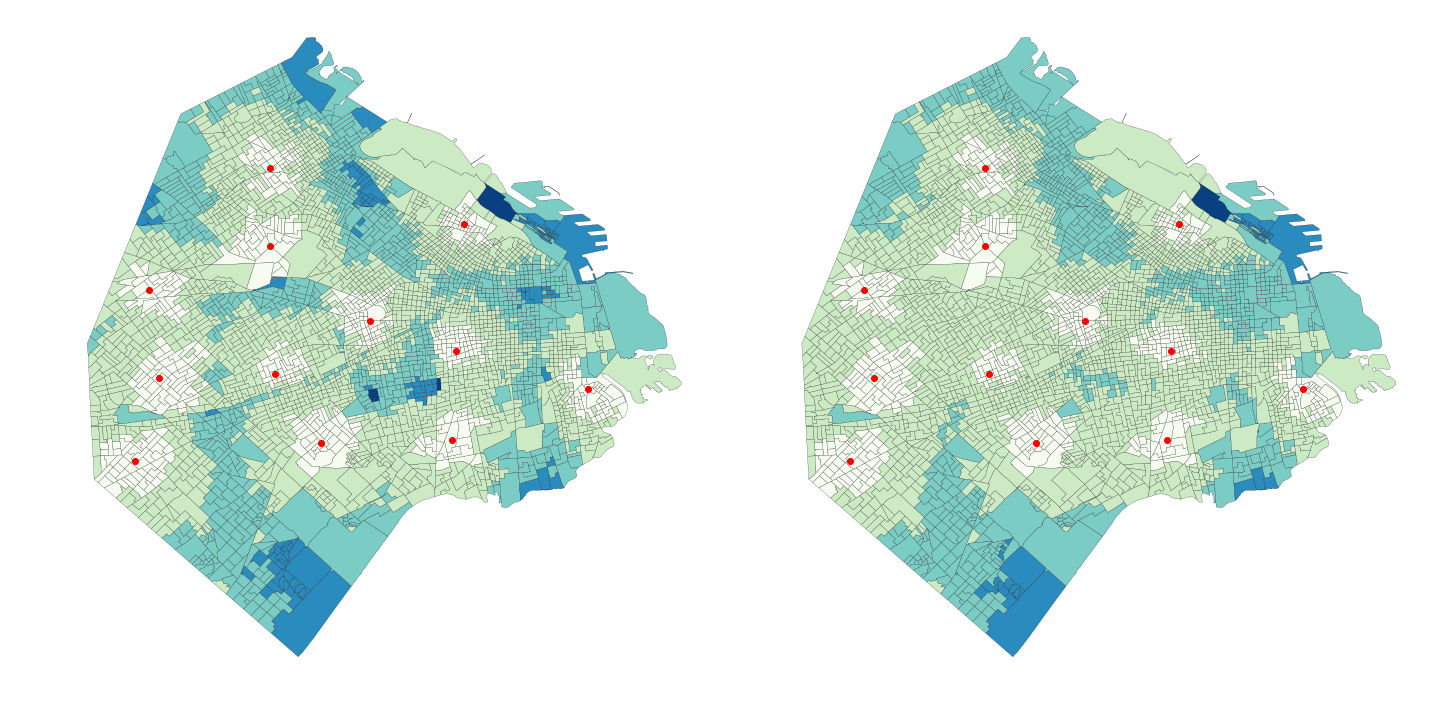

In [115]:
fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1,figsize=(20,10))

plot1.plot(column='area_levels', cmap='GnBu', ax=ax1, edgecolor='black', linewidth=0.2, vmin=0, vmax=4)
hosps.plot(ax = ax1, color='red')

plot1.plot(column='gmap_levels', cmap='GnBu', ax=ax2, edgecolor='black', linewidth=0.2, vmin=0, vmax=4)
hosps.plot(ax = ax2, color='red')

[ax.axis('off') for ax in [ax1, ax2]]
plt.tight_layout()
plt.savefig("assets/map_time.svg", format='svg')
plt.show()

In [93]:
plot2 = cityblock.loc[:, ['id','geometry']]

In [94]:
plot2['difference'] = cityblock.gmap_time - cityblock.area_time

In [95]:
plot2['diff_levels'] = pd.cut(
    plot2['difference'], [-800, -600, -300, -150, -75,-10, -1,0], labels=np.arange(7)
)

In [96]:
plot2 = gpd.GeoDataFrame(plot2)

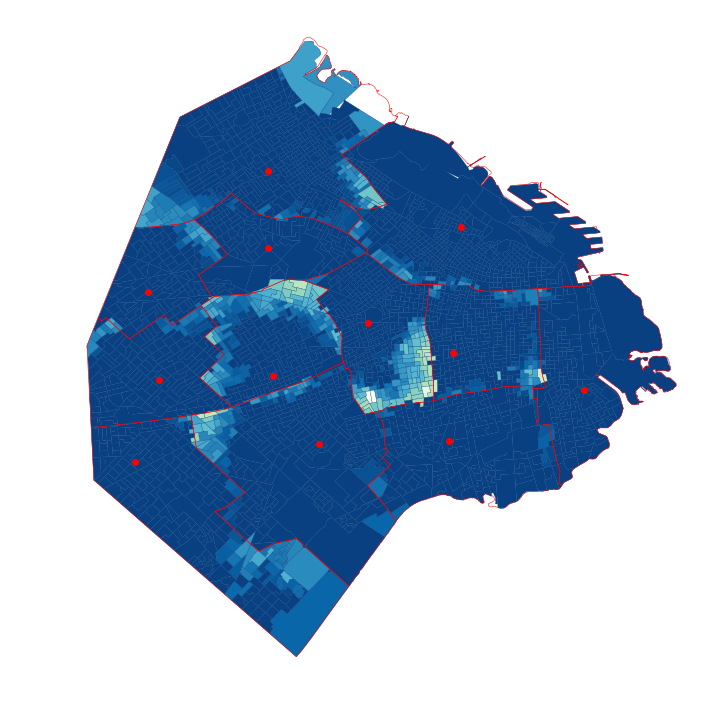

In [110]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,10))

plot2.plot(column='difference', cmap='GnBu', edgecolor='#084081', linewidth=0.3, ax=ax)
areas.plot(ax = ax, edgecolor='red', color='None', linewidth=0.5)
hosps.plot(ax = ax, color='red')

ax.axis('off')
plt.tight_layout()
plt.savefig("assets/map_time_save.svg", format='svg')
plt.show()